# Reliability
Thie notebook focuses on importing, processing, and determining at what times the beacon and Fitbit data were being recorded. The notebook outline is 

1. [Beacon](#Beacon-Data)

    1. [Data Import](#Data-Import)
    2. [Reliability](#Reliability)
    
1. [Fitbit](#Fitbit-Data)

    1. [UT1000](#FB-UT1000)
    2. [UT2000](#FB-UT2000)
    
1. [Saving Data Files](#Combining-and-Saving-Data)

In [1]:
# Basics
import csv
import math
import numpy as np
import pandas as pd
from pathlib import Path
import os
import math
os.environ['PROJ_LIB'] = '/anaconda3/share/proj'

# Plotting Tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
import seaborn as sns
from matplotlib.cm import ScalarMappable

# Statistics
from scipy import stats
import statsmodels.api as sm

In [2]:
ID_byDeployment = pd.Series()
for i in range(3): # number of deployments
    temp = pd.read_excel('~/Projects/utx000/data/raw/ut2000/admin/WCWH_IDs.xlsx', sheet_name=str(i+1),usecols=[0,1,2],names=['Fitabase','Beiwe','Beacon'])
    for j in range(len(temp)):
        temp.iloc[j,1] = temp.iloc[j,1].replace(u'\xa0', u'')
    temp = temp.sort_values(by=['Fitabase'])
    ID_byDeployment[str(i+1)] = temp

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


# Beacon Data 
The following cells import and determine the times when the data are available for the beacons.

<div class="alert alert-block alert-danger">
<b>No UT1000 Data:</b> The data gathered from the beacons for the UT1000 deployment are sparse (only 3 beacons recorded data), intermittent at best, and in an odd format. For these reasons, the UT1000 beacon data are excluded from this and most other analyses.
</div>

## UT2000
The format of the UT2000 data is unique to that deployment. Therefore we have specific functions.

### Deployment-Specific Functions

In [3]:
def getAQI(concentration):
    '''
    Input:
        - concentration: numpy float array holding the PM2.5 concentrations in ug/m^3
    Returns the PM2.5 concentration as and air quality index
    '''
    aqi = []
    for C in concentration:
        if C <= 12.0:
            aqi_score = round(C/12.0 * 50.0)
            aqi.append(aqi_score)
        elif C <= 35.4:
            aqi_score = round(50 + (C-12.1)/(35.4-12.1) * (100-50))
            aqi.append(aqi_score)
        elif C <= 55.4:
            aqi_score = round(100 + (C-35.5)/(55.4-35.5) * (150-100))
            aqi.append(aqi_score)
        elif C <= 150.4:
            aqi_score = round(150 + (C-55.5)/(150.4-55.5) * (200-150))
            aqi.append(aqi_score)
        elif C <= 250.4:
            aqi_score = round(200 + (C-150.5)/(250.4-150.5) * (300-200))
            aqi.append(aqi_score)
        elif C <= 350.4:
            aqi_score = round(300 + (C-250.5)/(350.4-250.5) * (400-300))
            aqi.append(aqi_score)
        else:
            aqi_score = round(400 + (C-350.5)/(500.4-350.5) * (500-400))
            aqi.append(aqi_score)
            
    return aqi

In [4]:
def ieqImport(beiwe_ids, beacons, directory, name_list, column_list):
    '''
    Inputs:
        - deployment_info: a list of strings that contains the semester, deployment tag, deployment number,
            starting date, and ending date of deployment
        - beiwe_ids: a list of the beiwe IDs from this data set
        - beacons: a list of the beacons from this data set
        - directory: the final directory where the data is stored
        - name_list: a list of strings for the columns to be used in the dataframe - a 'time' column is assumed to exist
        - column_list: a list of numbers that correspond to the columns to be imported, default is 'all'
    Imports different IEQ data variables and returns a Series object that contains dataframes for the specified IEQ variable
    '''
    data_total = pd.Series() # Dataframe to return
    for i in range(len(beacons)):
        start_time = datetime.now()
        if beacons[i] < 10:
            beacon_no = '0' + str(beacons[i])
        else:
            beacon_no = str(beacons[i])
        #DIR = 'Spring2019_Deployments/3_Deployment/Beacon_Data/beacon-d3' + '-' + beacon_no + '/bevo/' + directory + '/'
        DIR = f'/Users/hagenfritz/Projects/utx000/data/raw/ut2000/beacon/beacon-d3-{beacon_no}/bevo/{directory}/'
        # Importing Data
        data_beacon = pd.DataFrame()
        for file in os.listdir(DIR):
            if str(file[-3:]) == 'csv': # To ensure that we only read in csv files
                data_csv = pd.read_csv(DIR + file,header=None,names=name_list,usecols=column_list)
                data_beacon = pd.concat([data_beacon,data_csv],axis=0,ignore_index=True)
        ## Getting datetime index
        data_beacon = data_beacon.dropna() # Dropping any NaNs
        
        ## Adding deployment and id columns
        data_beacon['Deployment'] = 3
        data_beacon['ID'] = beiwe_ids[i]
        data_total = pd.concat([data_total,data_beacon],axis=0,ignore_index=True)
        
        end_time = datetime.now()    
        print('Total elapsed time to import data from Beacon '+str(beacon_no)+': '+str(end_time - start_time))
        
    t = np.zeros((len(data_total)),dtype='datetime64[ns]') # Array to store times
    for j in range(len(t)):
        ts = int(data_total['time'].values[j])
        t[j] = datetime.strptime(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S') - timedelta(hours=5)
    ## Re-indexing and re-naming
    data_total['DateTime'] = t
    data_total = data_total.set_index('DateTime')
    data_total = data_total.sort_index()
    data_total = data_total.drop(['time'],axis=1)

    return data_total

<div class="alert alert-block alert-warning">
<b>Warning:</b> The function above to import data is unique to the UT2000 beacons - Bevo Beacon 2.0 i.e. the one with the acryllic sides. This version has since been deprecated. 
</div>

## Data Import
Now we import the data for the beacons starting with thermal comfort (TC), then particulate matter (PM), and finally total volatile organic compounds (TVOCs). Each sensor is separated into its own directory hence the three calls to the ```ieqImport``` function.

In [5]:
print('Importing data for Thermal Comfort')
TC = ieqImport(ID_byDeployment['3']['Beiwe'],ID_byDeployment['3']['Beacon'],'sht31d',['time','RH','TC'],[0,1,2])
TC['TF'] = TC['TC']*1.8+32
print('Import Complete'.upper())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


Importing data for Thermal Comfort
Total elapsed time to import data from Beacon 07: 0:00:00.227983
Total elapsed time to import data from Beacon 12: 0:00:00.145585
Total elapsed time to import data from Beacon 09: 0:00:00.166663
Total elapsed time to import data from Beacon 03: 0:00:00.240240
Total elapsed time to import data from Beacon 08: 0:00:00.059691
Total elapsed time to import data from Beacon 02: 0:00:00.243661
Total elapsed time to import data from Beacon 01: 0:00:00.220644
Total elapsed time to import data from Beacon 06: 0:00:00.209996
Total elapsed time to import data from Beacon 05: 0:00:00.220430
Total elapsed time to import data from Beacon 10: 0:00:00.289256
IMPORT COMPLETE


In [6]:
print('Importing data for PM')
PM = ieqImport(ID_byDeployment['3']['Beiwe'],ID_byDeployment['3']['Beacon'],'pms5003',['time','Concentration'],[0,2])
PM['AQI'] = getAQI(PM['Concentration'])
print('Import Complete'.upper())

Importing data for PM
Total elapsed time to import data from Beacon 07: 0:00:00.092354
Total elapsed time to import data from Beacon 12: 0:00:00.045658


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


Total elapsed time to import data from Beacon 09: 0:00:00.068178
Total elapsed time to import data from Beacon 03: 0:00:00.121605
Total elapsed time to import data from Beacon 08: 0:00:00.023599
Total elapsed time to import data from Beacon 02: 0:00:00.158200
Total elapsed time to import data from Beacon 01: 0:00:00.174792
Total elapsed time to import data from Beacon 06: 0:00:00.101546
Total elapsed time to import data from Beacon 05: 0:00:00.192252
Total elapsed time to import data from Beacon 10: 0:00:00.040490
IMPORT COMPLETE


In [7]:
print('Importing data for TVOCs')
TVOC = ieqImport(ID_byDeployment['3']['Beiwe'],ID_byDeployment['3']['Beacon'],'sgp30',['time','eCO2','Concentration'],[0,1,2])
print('Import Complete'.upper())

Importing data for TVOCs
Total elapsed time to import data from Beacon 07: 0:00:00.187478


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


Total elapsed time to import data from Beacon 12: 0:00:00.170903
Total elapsed time to import data from Beacon 09: 0:00:00.157912
Total elapsed time to import data from Beacon 03: 0:00:00.174604
Total elapsed time to import data from Beacon 08: 0:00:00.053307
Total elapsed time to import data from Beacon 02: 0:00:00.187212
Total elapsed time to import data from Beacon 01: 0:00:00.245702
Total elapsed time to import data from Beacon 06: 0:00:00.212236
Total elapsed time to import data from Beacon 05: 0:00:00.261744
Total elapsed time to import data from Beacon 10: 0:00:00.287753
IMPORT COMPLETE


## Reliability
Lastly, we generate a figure based on the percentage of beacons operating at certain times during the UT2000 deployment.

In [8]:
def get_reliability_dfs(df, var, id_col):
    '''
    Creates the dataframe used to generate the reliability figure for the beacon.
    '''
    frames = []
    for participant in df[id_col].unique():
        df_by_id = df[df[id_col] == participant]
        df_resampled = df_by_id.resample(timedelta(minutes=10)).mean()

        frames.append(df_resampled[var])
        
    overall_hourly = pd.concat(frames,axis=1,join='outer').resample(timedelta(hours=1)).count()
    overall_hourly['percentage'] = overall_hourly.sum(axis=1)/(len(df[id_col].unique())*6)
    overall_hourly['day'] = overall_hourly.index.date
    overall_daily = pd.concat(frames,axis=1,join='outer').resample(timedelta(days=1)).count()
    overall_daily['percentage'] = overall_daily.sum(axis=1)/(len(df[id_col].unique())*144)
    overall_daily['day'] = overall_daily.index.date
    
    overall = overall_hourly.merge(right=overall_daily, left_on='day', right_on='day', how='left')
    overall['DateTime'] = overall_hourly.index
    overall = overall.set_index('DateTime')
    
    return overall

### Getting hourly and daily averages
Uses the above function and puts the dataframes into a list that we can loop through.

In [9]:
pm = get_reliability_dfs(PM,'Concentration','ID')
tvoc = get_reliability_dfs(TVOC,'Concentration','ID')
t = get_reliability_dfs(TC,'TF','ID')
dfs = [pm,tvoc,t]

### Plotting the figure
Figure is based upon Peter W.'s reliability figure. 

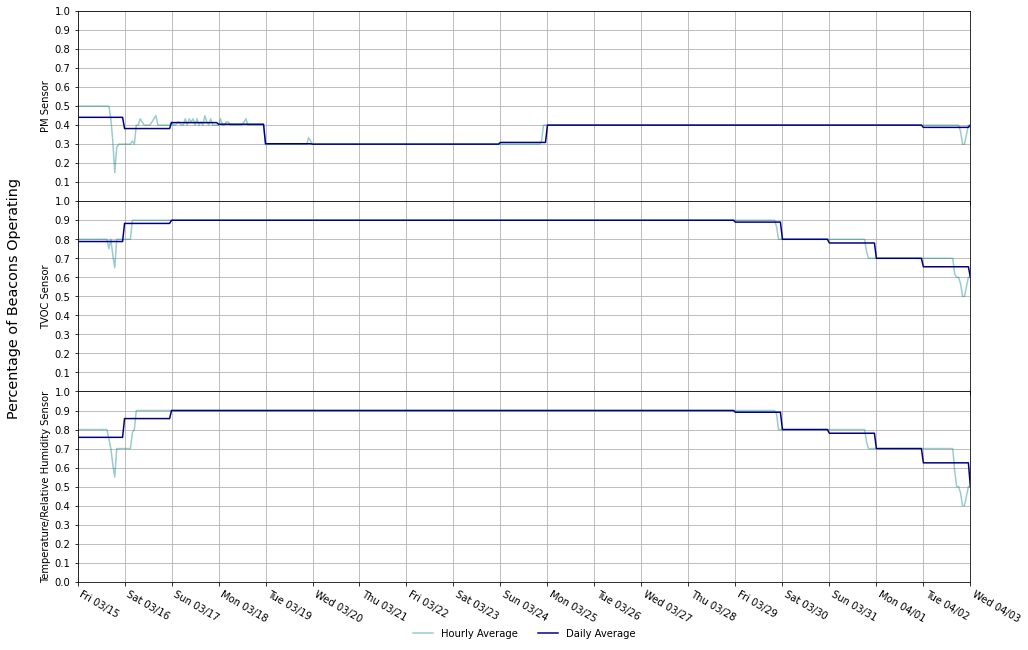

In [10]:
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(16,10.5))
count = 0
sensors = ['PM','TVOC','Temperature/Relative Humidity']
for i in range(len(dfs)):
    df = dfs[i][datetime(2019,3,15):datetime(2019,4,3)]
    # Plotting Data
    ax[i].plot(df.index,df['percentage_x'],color='teal',alpha=0.4, label='Hourly Average')
    ax[i].plot(df.index,df['percentage_y'],color='navy', label='Daily Average')
    
    ## Formatting y-axis
    ax[i].set_ylim([0,1])
    ax[i].set_ylabel(sensors[i]+' Sensor')
    if i in [0,1]:
        ax[i].set_yticks(np.arange(0.1,1.1,0.1))
    else:
        ax[i].set_yticks(np.arange(0,1.1,0.1))
        
    # Formatting remainder
    ax[i].grid(which='both')
    #ax[i].set_title(sensors[i]+' Sensor',backgroundcolor='white')

## Formatting x-axis
ax[0].set_xlim([df.index[0],df.index[-1]])
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
plt.xticks(rotation=-30,ha='left')

ax[2].legend(loc='upper center',bbox_to_anchor=(0.5,-0.2),ncol=3,frameon=False)

fig.text(0.07, 0.5, 'Percentage of Beacons Operating', ha='center', va='center', rotation='vertical',fontsize='x-large')
plt.savefig(f'/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut2000_beacon_reliability.png')
plt.show()
plt.close()

# Fitbit Data
The Fitbit data spans across both deployments and is in the same format (yay!).

## Fitbit-Specific Functions

In [11]:
def fitbitImport(deployment_info, beiwe_ids, record_ids, file_name, name_list, daily=True):
    '''
    Inputs:
        - deployment_info: a list of strings that contains the semester, deployment tag, deployment number,
            starting date, and ending date of deployment
        - beiwe_ids: a list of string containing the beiwe IDs from this deployment's data set
        - record_ids: a list of strings containing the Fitbit IDs from this deployment's data set
        - file_name: a string that contains the file name we are looking for
        - name_list: a list of strings for the columns to be used in the dataframe
        - interval: a string that specifies whether data is hourly or daily
    Imports different Fitbit data variables and returns a Series object that contains dataframes for the specified Fitbit variable
    '''
    # Important variables
    df_byID = pd.Series() # Series to return
    start_date = deployment_info[3]
    end_date = deployment_info[4]
    DIR = deployment_info[0] + '/' + deployment_info[1] + '/Fitbit_Data/' # Directory where the file should be located
    
    # Importing the data from file
    try:
        raw_data = pd.read_csv(DIR + file_name, header=0, names=name_list)

        # Parsing out data by Fitbit ID
        ids = [raw_data.iloc[0]['ID']] # variable to store the various ids in the file
        ## Getting the IDs
        for i in range(len(raw_data)-1):
            if raw_data.iloc[i]['ID'] != raw_data.iloc[i+1]['ID']:
                ids.append(raw_data.iloc[i+1]['ID'])

        ## Converting the time column to datetime
        #print('Header of raw data\n', raw_data.head())
        if daily == True:
            raw_data['Time'] = pd.to_datetime(raw_data['Time'], format="%m/%d/%Y")
        else:
            raw_data['Time'] = pd.to_datetime(raw_data['Time'], format="%m/%d/%Y %I:%M:%S %p")

        raw_data = raw_data.set_index('Time')

        ## Storing into new Series
        data_byFBID = pd.Series() # Series holding dataframes for each Fitbit (FB) ID
        for i in range(len(ids)):
            data_byFBID[str(ids[i])] = raw_data[raw_data.ID == ids[i]]

        # Converting to Series by Beiwe ID
        df_byID = pd.Series() # Series holding dataframes for each Beiwe ID
        for i in range(len(data_byFBID)):
            for j in range(len(record_ids)):
                if str(data_byFBID.index[i]) == str(record_ids[j]):
                    temp = data_byFBID.iloc[i]
                    temp = temp[start_date:end_date]
                    if len(temp) > 0:
                        df_byID[str(beiwe_ids[j])] = temp

        return df_byID
    except FileNotFoundError:
        print('No file found - wrong path')

In [12]:
def get_fb_reliability(df, var, id_col, time_col, resample_time):
    '''
    
    '''
    frames = []
    for participant in df[id_col].unique():
        df_by_id = df[df[id_col] == participant]
        df_by_id[time_col] = pd.to_datetime(df_by_id[time_col])
        df_by_id = df_by_id.set_index(time_col)
        df_resampled = df_by_id.resample(timedelta(minutes=resample_time)).mean()

        frames.append(df_resampled[var])
        
    overall_hourly = pd.concat(frames,axis=1,join='outer').resample(timedelta(hours=1)).count()
    overall_hourly['percentage'] = overall_hourly.sum(axis=1)/(len(df[id_col].unique())*(60/resample_time))
    overall_hourly['day'] = overall_hourly.index.date
    overall_daily = pd.concat(frames,axis=1,join='outer').resample(timedelta(days=1)).count()
    overall_daily['percentage'] = overall_daily.sum(axis=1)/(len(df[id_col].unique())*24*(60/resample_time))
    overall_daily['day'] = overall_daily.index.date
    
    overall = overall_hourly.merge(right=overall_daily, left_on='day', right_on='day', how='left')
    overall['DateTime'] = overall_hourly.index
    overall = overall.set_index('DateTime')
    
    return overall
        

## FB UT1000

In [100]:
HR15_1 = pd.read_csv('/Users/hagenfritz/Projects/utx000/data/raw/ut1000/fitbit/heartrate_15min_merged.csv')
cal_hourly = pd.read_csv('/Users/hagenfritz/Projects/utx000/data/raw/ut1000/fitbit/hourlyCalories_merged.csv')

<div class="alert alert-block alert-warning">
<b>Reliability Representation:</b> Since Fitbit is measuring multiple metrics at somewhat consistent intervals, we have multiple options to check reliability with. The two that seem the most promising are <b>heart rate</b> and <b>calories</b>.
</div>

### Heart Rate
Data reliability based on the 15-minute heart rate intervals

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


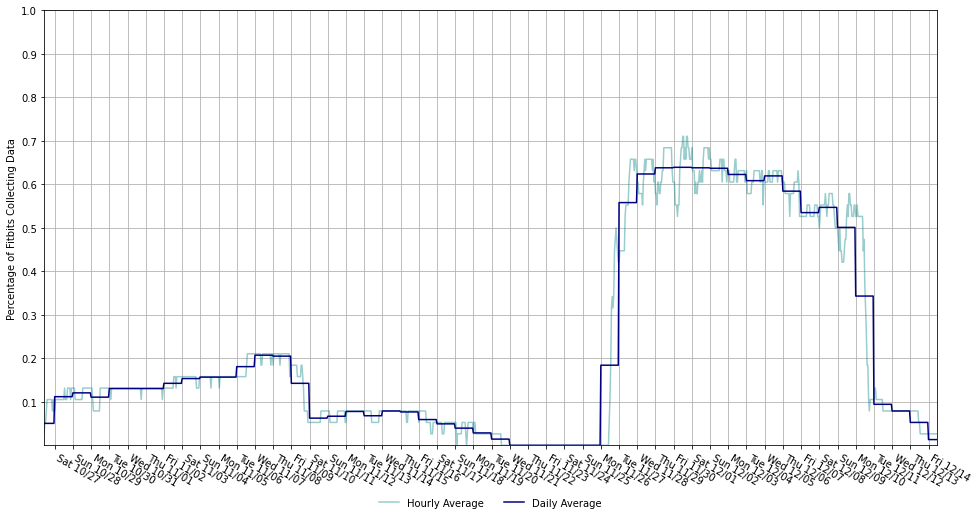

In [14]:
HR15 = HR15_1
df = get_fb_reliability(df=HR15,var='Value',id_col='Id',time_col='Time',resample_time=60)
fig,ax = plt.subplots(figsize=(16,8))

#df = df[datetime(2019,3,15):datetime(2019,4,2)]
# Plotting Data
ax.plot(df.index,df['percentage_x'],color='teal',alpha=0.4, label='Hourly Average')
ax.plot(df.index,df['percentage_y'],color='navy', label='Daily Average')

## Formatting y-axis
ax.set_ylim([0,1])
ax.set_ylabel('Percentage of Fitbits Collecting Data')
ax.set_yticks(np.arange(0.1,1.1,0.1))

# Formatting remainder
ax.grid(which='both')
#ax[i].set_title(sensors[i]+' Sensor',backgroundcolor='white')

## Formatting x-axis
ax.set_xlim([df.index[0],df.index[-1]])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xticks(rotation=-30,ha='left')

ax.legend(loc='upper center',bbox_to_anchor=(0.5,-0.1),ncol=3,frameon=False)

plt.savefig(f'/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut1000_fitbit_reliability_onHR.png')
plt.show()
plt.close()

### Calories

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


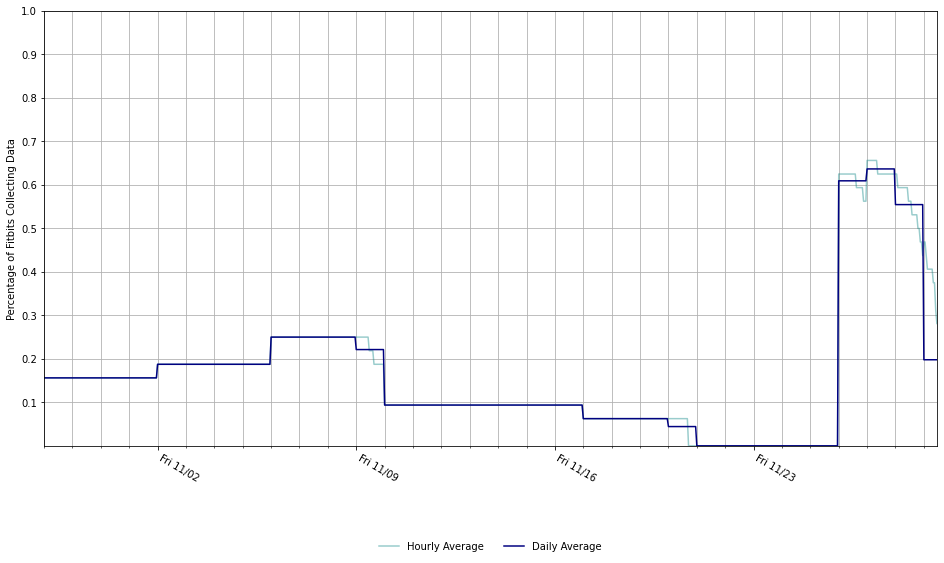

In [15]:
df = get_fb_reliability(cal_hourly,'Calories','Id','ActivityHour',60) 
fig,ax = plt.subplots(figsize=(16,8))

# Plotting Data
ax.plot(df.index,df['percentage_x'],color='teal',alpha=0.4, label='Hourly Average')
ax.plot(df.index,df['percentage_y'],color='navy', label='Daily Average')

## Formatting y-axis
ax.set_ylim([0,1])
ax.set_ylabel('Percentage of Fitbits Collecting Data')
ax.set_yticks(np.arange(0.1,1.1,0.1))

# Formatting remainder
ax.grid(which='both')
#ax[i].set_title(sensors[i]+' Sensor',backgroundcolor='white')

## Formatting x-axis
ax.set_xlim([df.index[0],df.index[-1]])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xticks(rotation=-30,ha='left')

ax.legend(loc='upper center',bbox_to_anchor=(0.5,-0.2),ncol=3,frameon=False)

plt.savefig(f'/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut1000_fitbit_reliability_onCals.png')
plt.show()
plt.close()

## FB UT2000

In [101]:
HR15_2 = pd.read_csv('/Users/hagenfritz/Projects/utx000/data/raw/ut2000/fitbit/heartrate_15min_merged.csv')
cal_hourly = pd.read_csv('/Users/hagenfritz/Projects/utx000/data/raw/ut2000/fitbit/hourlyCalories_merged.csv')

### Heart Rate

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


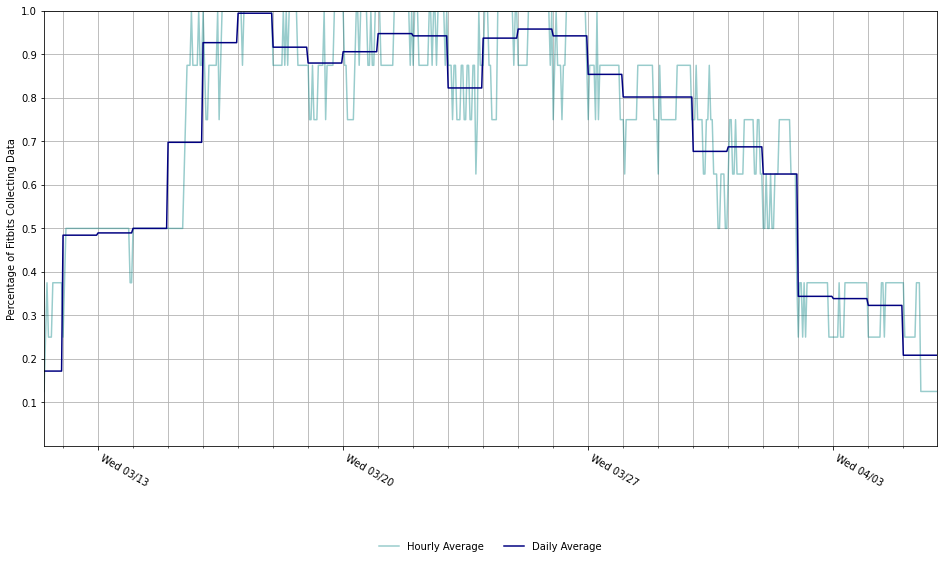

In [17]:
HR15 = HR15_2
df = get_fb_reliability(HR15,'Value','Id','Time',60) 
fig,ax = plt.subplots(figsize=(16,8))

# Plotting Data
ax.plot(df.index,df['percentage_x'],color='teal',alpha=0.4, label='Hourly Average')
ax.plot(df.index,df['percentage_y'],color='navy', label='Daily Average')

## Formatting y-axis
ax.set_ylim([0,1])
ax.set_ylabel('Percentage of Fitbits Collecting Data')
ax.set_yticks(np.arange(0.1,1.1,0.1))

# Formatting remainder
ax.grid(which='both')
#ax[i].set_title(sensors[i]+' Sensor',backgroundcolor='white')

## Formatting x-axis
ax.set_xlim([df.index[0],df.index[-1]])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xticks(rotation=-30,ha='left')

ax.legend(loc='upper center',bbox_to_anchor=(0.5,-0.2),ncol=3,frameon=False)

plt.savefig(f'/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut2000_fitbit_reliability_onHR.png')
plt.show()
plt.close()

### Calories

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


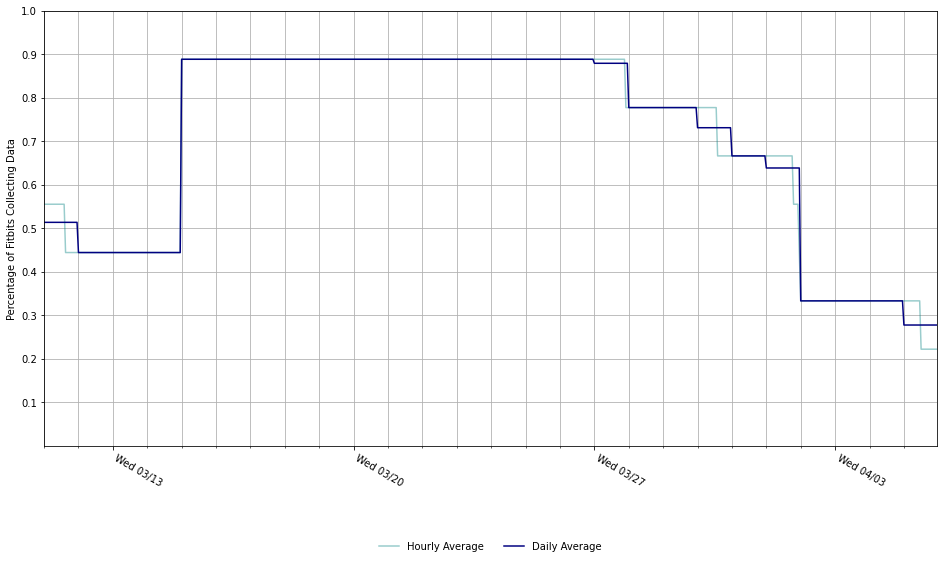

In [18]:
df = get_fb_reliability(cal_hourly,'Calories','Id','ActivityHour',60) 
fig,ax = plt.subplots(figsize=(16,8))

# Plotting Data
ax.plot(df.index,df['percentage_x'],color='teal',alpha=0.4, label='Hourly Average')
ax.plot(df.index,df['percentage_y'],color='navy', label='Daily Average')

## Formatting y-axis
ax.set_ylim([0,1])
ax.set_ylabel('Percentage of Fitbits Collecting Data')
ax.set_yticks(np.arange(0.1,1.1,0.1))

# Formatting remainder
ax.grid(which='both')
#ax[i].set_title(sensors[i]+' Sensor',backgroundcolor='white')

## Formatting x-axis
ax.set_xlim([df.index[0],df.index[-1]])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xticks(rotation=-30,ha='left')

ax.legend(loc='upper center',bbox_to_anchor=(0.5,-0.2),ncol=3,frameon=False)

plt.savefig(f'/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut2000_fitbit_reliability_onCals.png')
plt.show()
plt.close()

# Combining and Saving Data
Peter W. asked for some dataframes with the reliability data for the beacon and for the Fitbit. The following cells help to summarize the data in the format he asked for.

## Beacon Data
 The following cells summarize the beacon data according to the format below:

| Measure   |   Hour                            |   Participant    |    Has data? |
|---|---|---|---|
| TVOC       |   00:00 2019-03-01       |   abc123g        |    yes (or 1) |
| TVOC       |   01:00 2019-03-01       |   abc123g        |    no (or 0)  |
| TVOC       |   02:00 2019-03-01       |   abc123g        |    yes (or 1)  |
| ...              |   ....                               |   ...                   |    

### Beacon Data by Single Measure
Here we separate out each participant and each beacon measure.

In [30]:
df_to_save = pd.DataFrame()
for beacon_df,var in zip([TC,PM,TVOC],['TC','AQI','Concentration']):
    hourly_beacon_df = pd.DataFrame()
    for bid in beacon_df['ID'].unique():
        beacon_by_id = beacon_df[beacon_df['ID'] == bid]
        beacon_by_id = beacon_by_id.resample('1h').mean()
        beacon_by_id['ID'] = bid
        hourly_beacon_df = pd.concat([hourly_beacon_df,beacon_by_id])
        
    has_data = np.where(hourly_beacon_df[var] >= 0, 1, 0)
    df_by_measure = pd.DataFrame(data={'Hour':hourly_beacon_df.index.values,'Participant':hourly_beacon_df['ID'].values,'Has data?':has_data})
    if var == 'TC':
        measure_tag = 'TRH'
    elif var == 'AQI':
        measure_tag = 'PM'
    else:
        measure_tag = 'TVOC'
        
    df_by_measure['Measure'] = measure_tag
    df_to_save = pd.concat([df_to_save,df_by_measure])
        
df_to_save.to_csv(f'/Users/hagenfritz/Projects/utx000/data/processed/ut2000-beacon-sensor-reliability.csv')
    

#### Checking

TRH
19k2rlua
vvlm8iyi
uynulntv
36dsqll3
7ao7sz2v
e5z2mjax
fwx7pdjp
uuc9c1q8
td5gmdi8
tvydwa9w


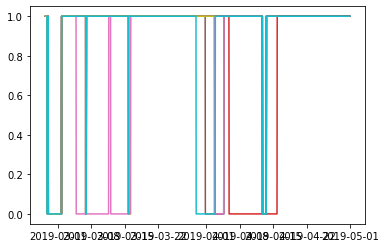

PM
uynulntv
7ao7sz2v
e5z2mjax
fwx7pdjp
td5gmdi8
vvlm8iyi
tvydwa9w
19k2rlua
36dsqll3
uuc9c1q8


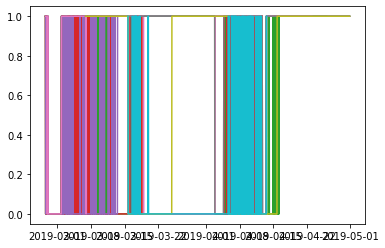

TVOC
19k2rlua
vvlm8iyi
tvydwa9w
uynulntv
36dsqll3
7ao7sz2v
e5z2mjax
fwx7pdjp
uuc9c1q8
td5gmdi8


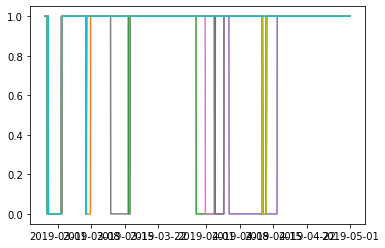

In [31]:
for measure in df_to_save['Measure'].unique():
    print(measure)
    fig, ax = plt.subplots()
    df_by_meas = df_to_save[df_to_save['Measure'] == measure]
    for bid in df_by_meas['Participant'].unique():
        print(bid)
        df_by_id = df_by_meas[df_by_meas['Participant'] == bid]
        ax.plot(df_by_id['Hour'],df_by_id['Has data?'])

    plt.show()
    plt.close()

### Beacon Data by Participant
I think we lose insight if we don't show the beacon measure together because some sensors might not have been working. In this case, we show all the sensor operation status for participant.

In [86]:
df_to_save = pd.DataFrame()
for bid in ID_byDeployment['3']['Beiwe']:
    beacon_df = pd.DataFrame()
    frames = []
    for var_df,var in zip([TC,PM,TVOC],['TC','AQI','Concentration']):
        var_by_id = var_df[var_df['ID'] == bid]
        var_by_id_hourly = var_by_id.resample('1h').mean()
        
        has_data = np.where(var_by_id_hourly[var] >= 0, 1, 0)
        if var == 'TC':
            measure_tag = 'TRH'
        elif var == 'AQI':
            measure_tag = 'PM'
        else:
            measure_tag = 'TVOC'
        df = pd.DataFrame(data={'Hour':var_by_id_hourly.index,measure_tag:has_data})
        df.set_index(['Hour'],inplace=True)
        df.sort_index(inplace=True)
        df = df[datetime(2019,3,15):datetime(2019,4,2,23)]
        frames.append(df)
        
    beacon_df = pd.concat(frames,join='outer')
    beacon_df['Participant'] = bid
    beacon_df.fillna(0,inplace=True)
    
    df_to_save = pd.concat([df_to_save,beacon_df])
    
df_to_save.to_csv(f'/Users/hagenfritz/Projects/utx000/data/processed/ut2000-beacon-sensor-reliability-participant.csv')
    

## Fitbit Data

<div class="alert alert-block alert-warning">
<b>Reliability Representation:</b> Heart rate seems to be the more appropriate form of gauging reliability from Fitbit. The data files that are saved are based upon this representation.
</div>

In [102]:
HR15_1.head() 

,Id,Time,Value
0,1025,10/26/2018 11:00:00 AM,69
1,1025,10/26/2018 11:30:00 AM,102
2,1025,10/26/2018 11:45:00 AM,86
3,1025,10/26/2018 12:00:00 PM,110
4,1025,10/26/2018 12:15:00 PM,118


In [103]:
HR15_2.head()

,Id,Time,Value
0,2040,3/11/2019 12:15:00 PM,103
1,2040,3/11/2019 12:30:00 PM,100
2,2040,3/11/2019 12:45:00 PM,114
3,2040,3/11/2019 1:00:00 PM,95
4,2040,3/11/2019 1:15:00 PM,85


In [105]:
df_to_save = pd.DataFrame()
for study_df,id_list in zip([HR15_1,HR15_2],[ID_byDeployment['2'],ID_byDeployment['3']]):
    for fid in study_df['Id'].unique():
        print(f'Working for ID {fid}:')
        start_time = datetime.now()
        # Getting Beiwe Id
        print(f'\tGetting Beiwe ID')
        bid = ''
        for i in range(len(id_list)):
            if id_list['Fitabase'][i] == fid:
                bid = id_list['Beiwe'][i]
                break
        print(f'\tBeiwe ID: {bid}')
        # Getting df for participant
        df_by_id = study_df[study_df['Id'] == fid]
        # Resampling to hourly
        print(f'\tReseting index and resampling')
        df_by_id = df_by_id.set_index(['Time'])
        df_by_id.index = pd.to_datetime(df_by_id.index)
        df_by_id_hourly = df_by_id.resample('1h').mean()
        # Getting new columns
        print(f'\tCreating new dataframe and adding to overall')
        has_data = np.where(df_by_id_hourly['Value'] > 10, 1, 0)
        # Appending to new dataframe
        df_to_add = pd.DataFrame(data={'Hour':df_by_id_hourly.index.values,'Has data?':has_data})
        df_to_add['Participant'] = bid
        df_to_save = pd.concat([df_to_save,df_to_add])
        end_time = datetime.now()
        print(f'\tElapsed time: {end_time-start_time}')
        
df_to_save.to_csv(f'/Users/hagenfritz/Projects/utx000/data/processed/ut3000-fitbit-reliability.csv') 

Working for ID 1025:
	Getting Beiwe ID
	Beiwe ID: 2qki3fim
	Reseting index and resampling
	Creating new dataframe and adding to overall
	Elapsed time: 0:00:00.147480
Working for ID 1041:
	Getting Beiwe ID
	Beiwe ID: ygny19ey
	Reseting index and resampling
	Creating new dataframe and adding to overall
	Elapsed time: 0:00:00.142457
Working for ID 1083:
	Getting Beiwe ID
	Beiwe ID: 5buzzcr7
	Reseting index and resampling
	Creating new dataframe and adding to overall
	Elapsed time: 0:00:00.112596
Working for ID 1126:
	Getting Beiwe ID
	Beiwe ID: ab4rv97k
	Reseting index and resampling
	Creating new dataframe and adding to overall
	Elapsed time: 0:00:00.095290
Working for ID 1168:
	Getting Beiwe ID
	Beiwe ID: z6foai1j
	Reseting index and resampling
	Creating new dataframe and adding to overall
	Elapsed time: 0:00:00.173082
Working for ID 1200:
	Getting Beiwe ID
	Beiwe ID: 23gjqvp5
	Reseting index and resampling
	Creating new dataframe and adding to overall
	Elapsed time: 0:00:00.052331
Work

#### Checking

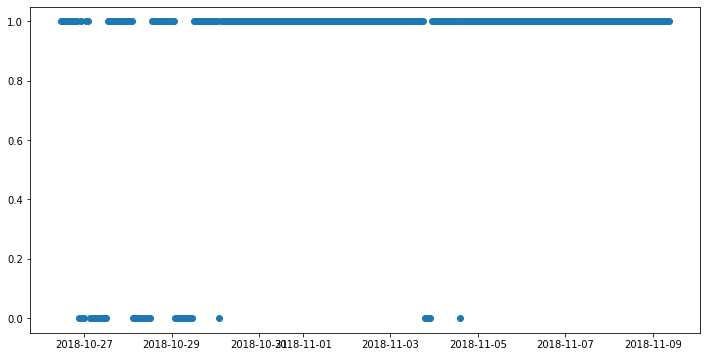

Percent Completion: 0.8835820895522388


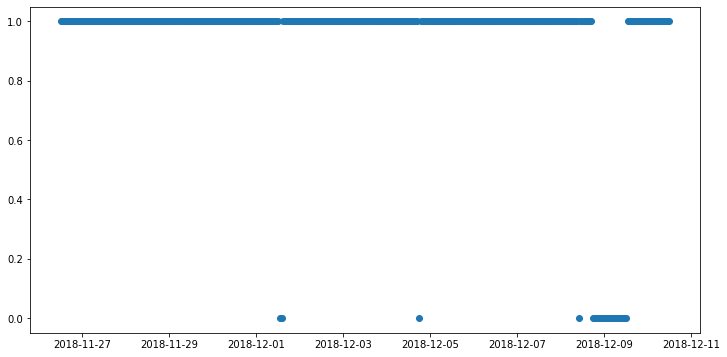

Percent Completion: 0.9317507418397626


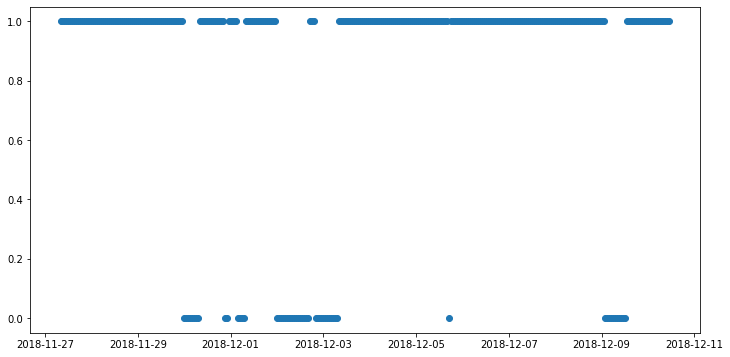

Percent Completion: 0.8259493670886076


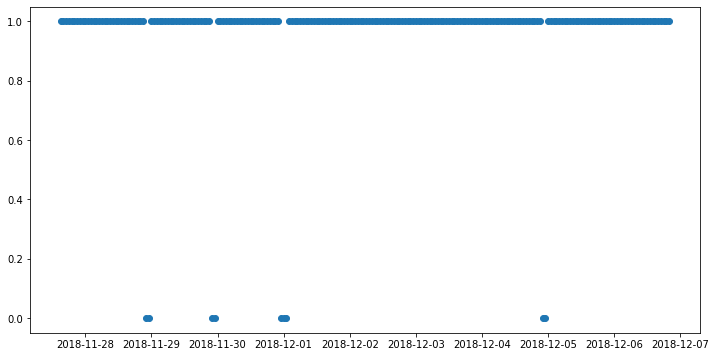

Percent Completion: 0.9594594594594594


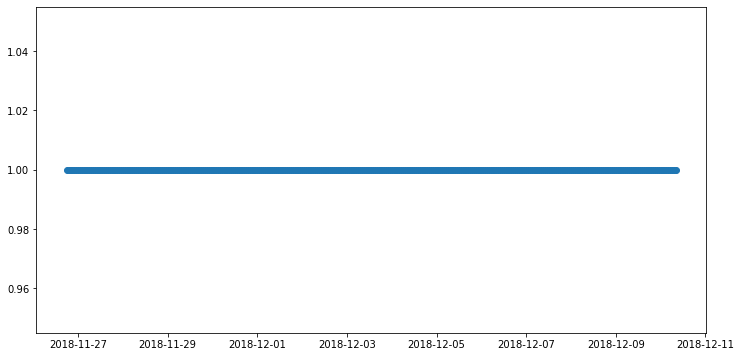

Percent Completion: 1.0


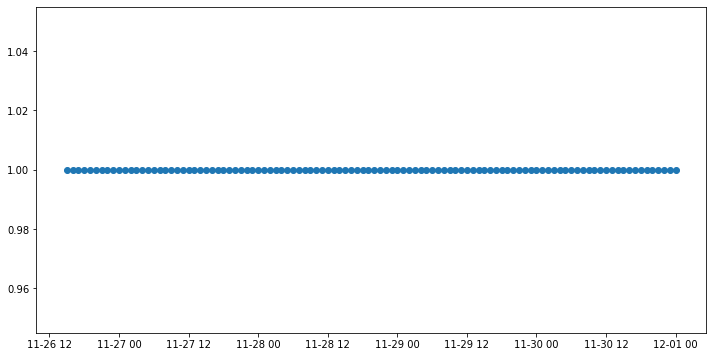

Percent Completion: 1.0


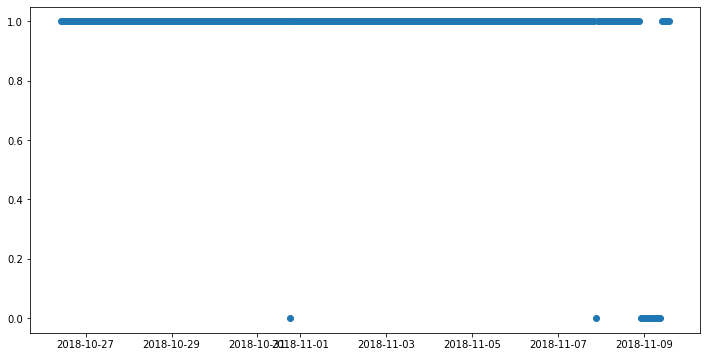

Percent Completion: 0.9589442815249267


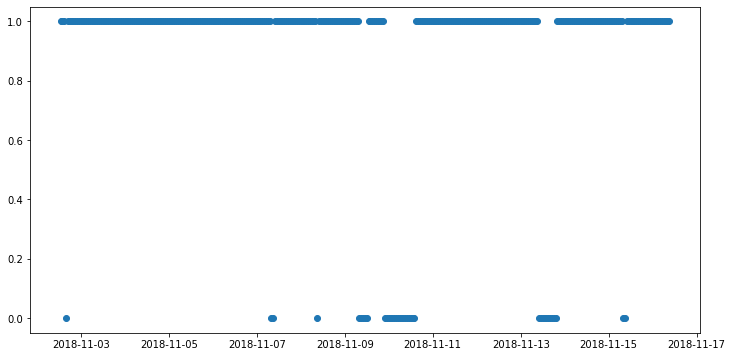

Percent Completion: 0.8858858858858859


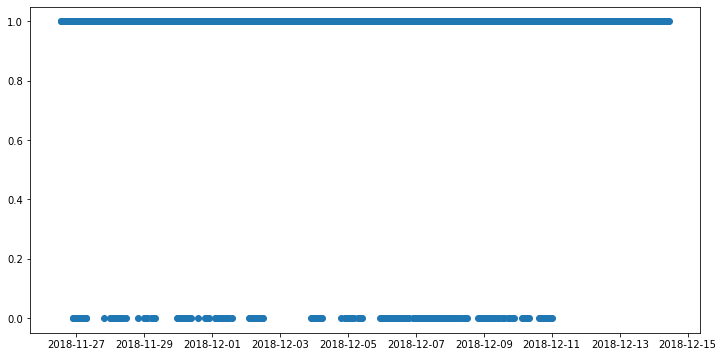

Percent Completion: 0.9140083217753121


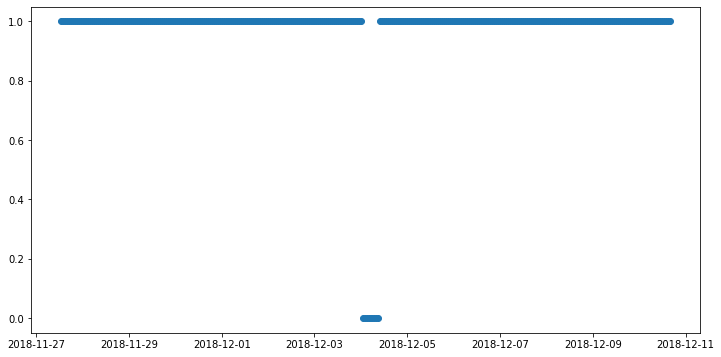

Percent Completion: 0.9715189873417721


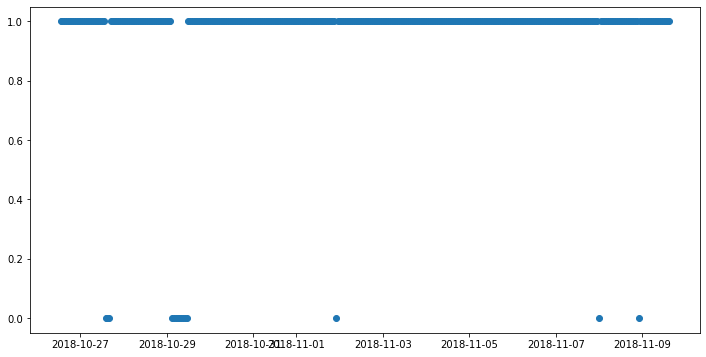

Percent Completion: 0.9557522123893806


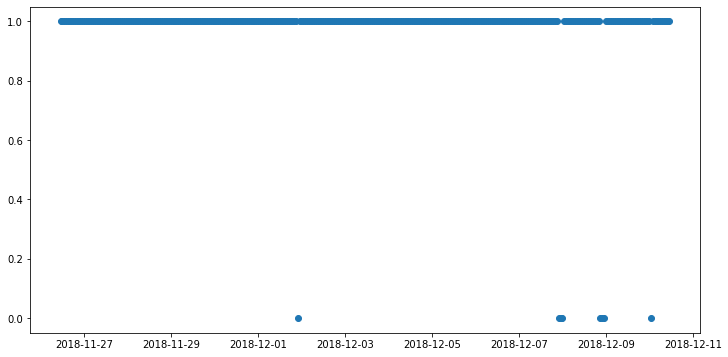

Percent Completion: 0.9762611275964391


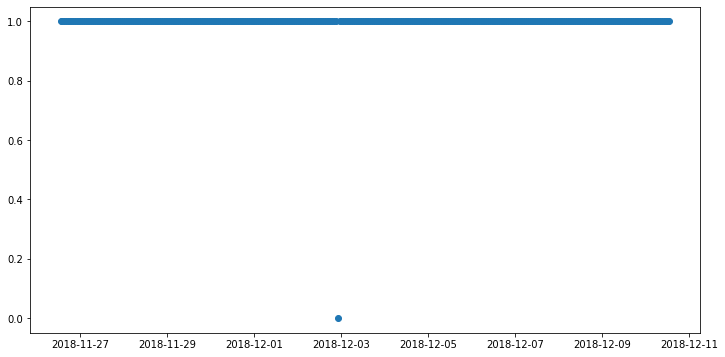

Percent Completion: 0.9970326409495549


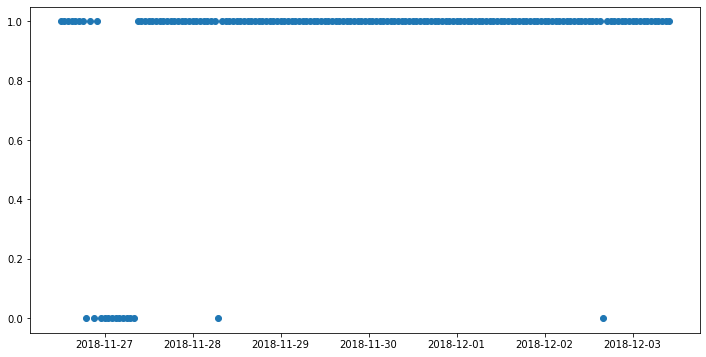

Percent Completion: 0.9161676646706587


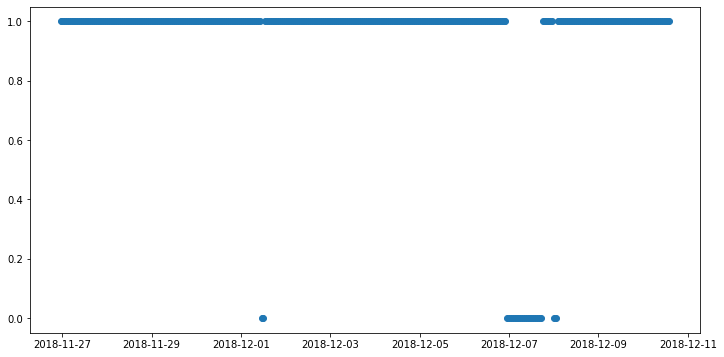

Percent Completion: 0.9298780487804879


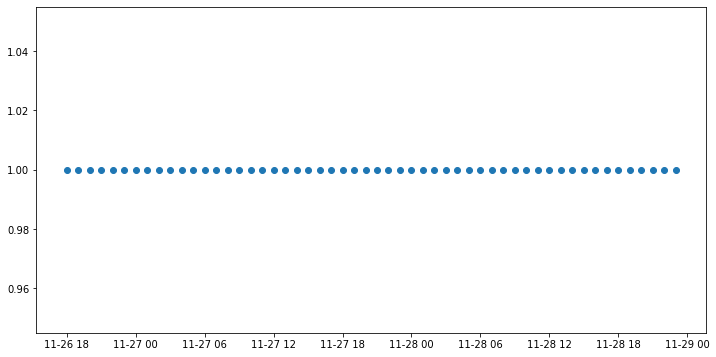

Percent Completion: 1.0


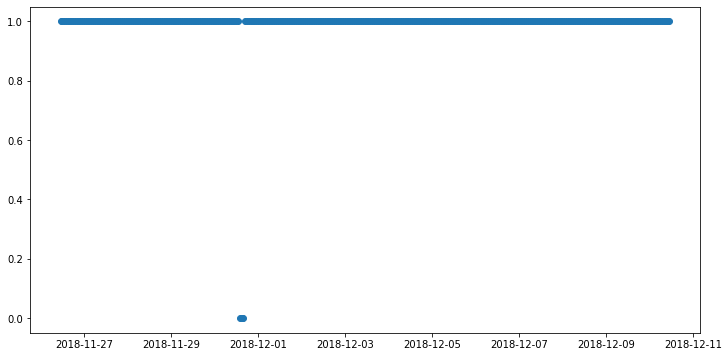

Percent Completion: 0.9910979228486647


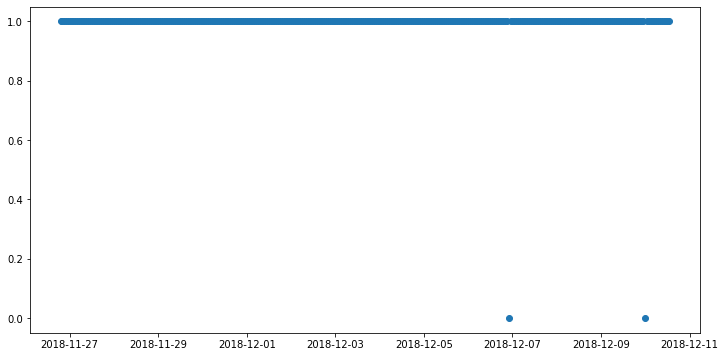

Percent Completion: 0.9939577039274925


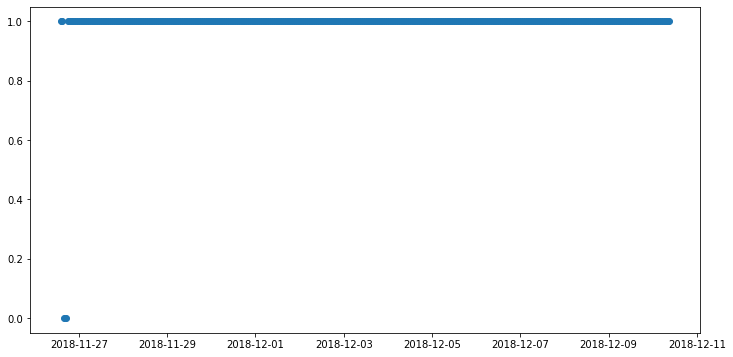

Percent Completion: 0.9939759036144579


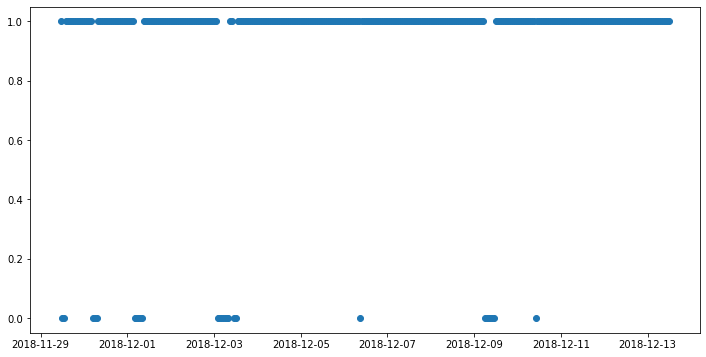

Percent Completion: 0.9201183431952663


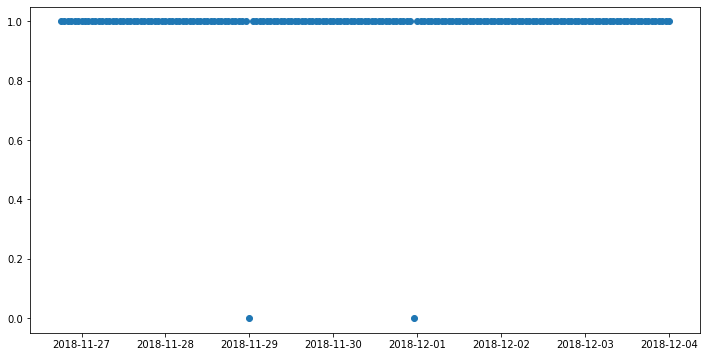

Percent Completion: 0.9885714285714285


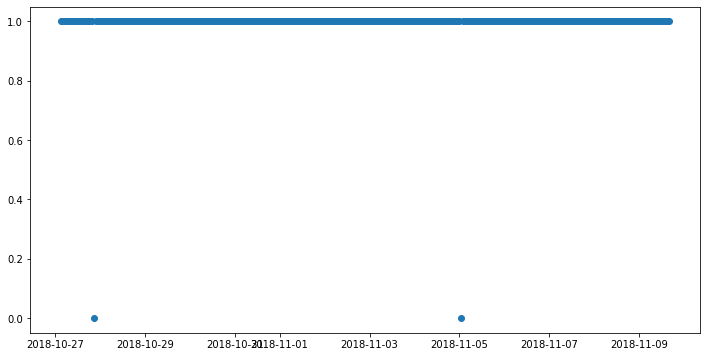

Percent Completion: 0.9938650306748467


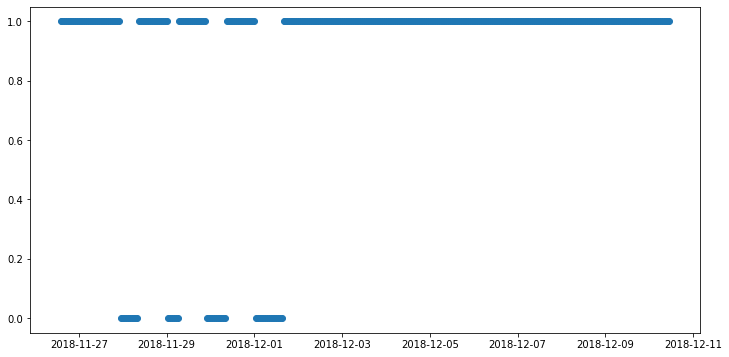

Percent Completion: 0.874251497005988


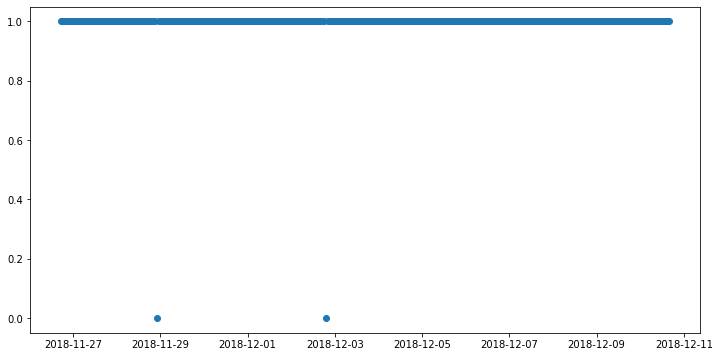

Percent Completion: 0.9940476190476191


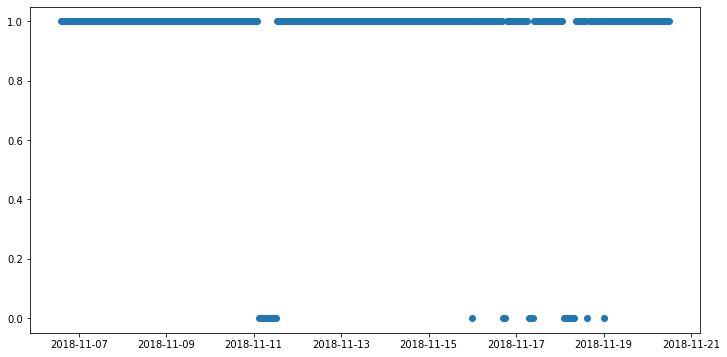

Percent Completion: 0.9253731343283582


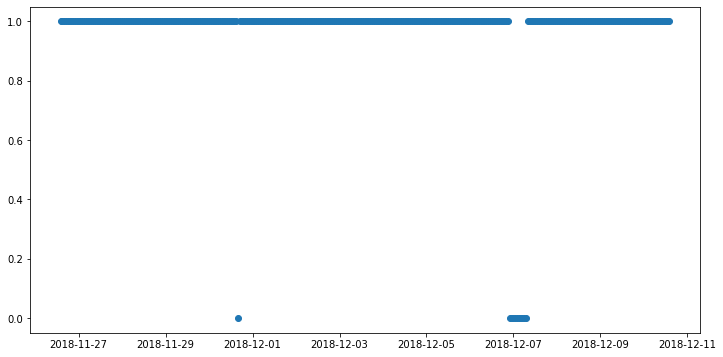

Percent Completion: 0.9673590504451038


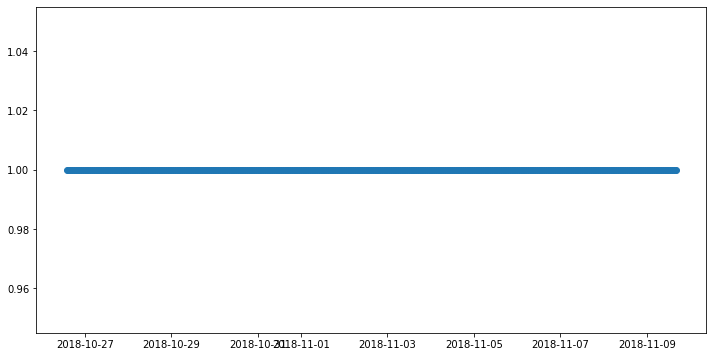

Percent Completion: 1.0


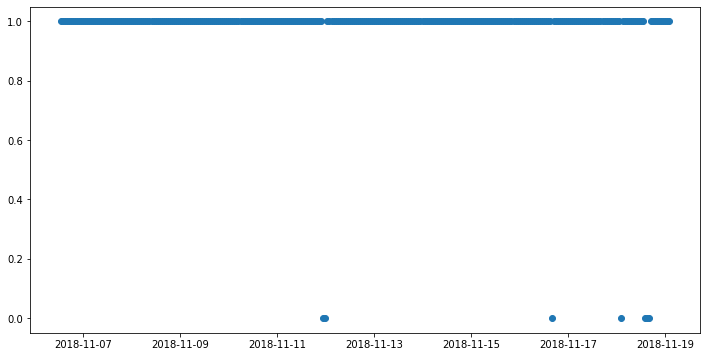

Percent Completion: 0.9768211920529801


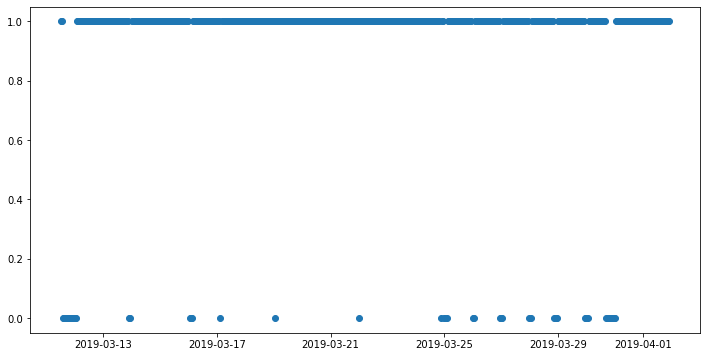

Percent Completion: 0.912621359223301


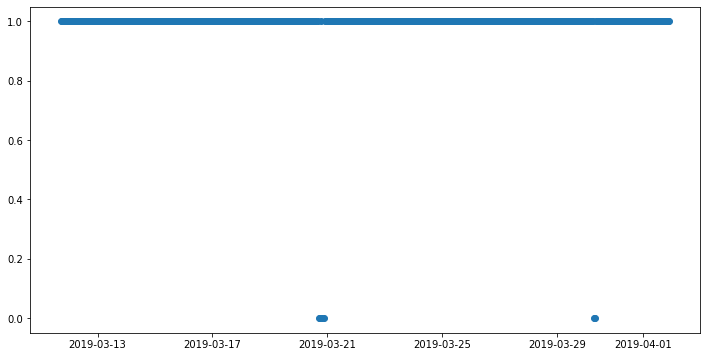

Percent Completion: 0.9882352941176471


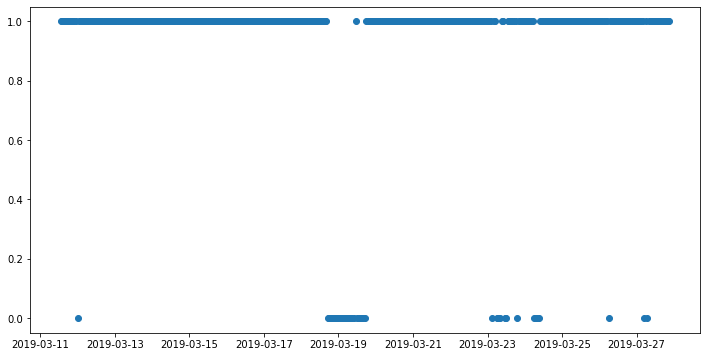

Percent Completion: 0.9007633587786259


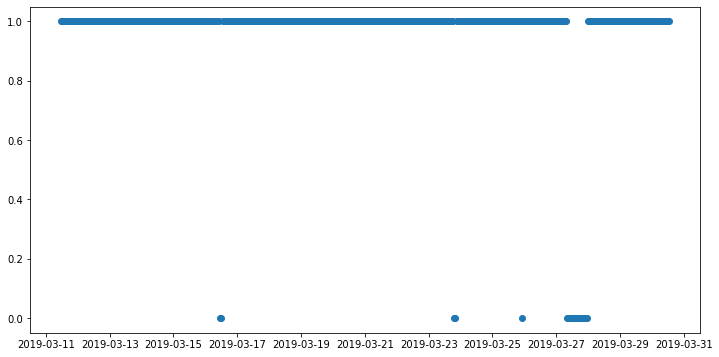

Percent Completion: 0.954248366013072


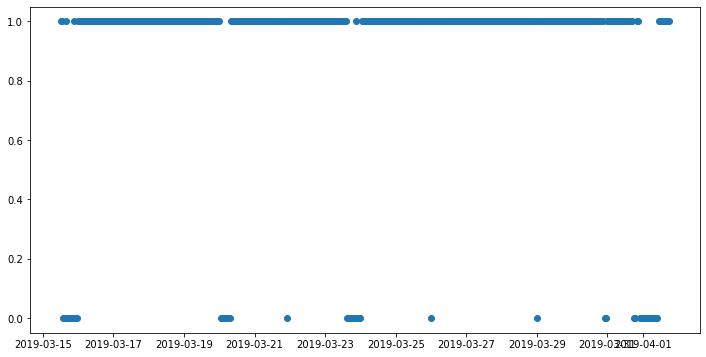

Percent Completion: 0.8939759036144578


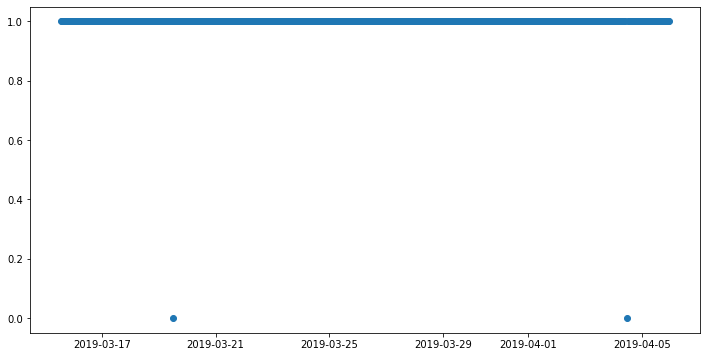

Percent Completion: 0.996116504854369


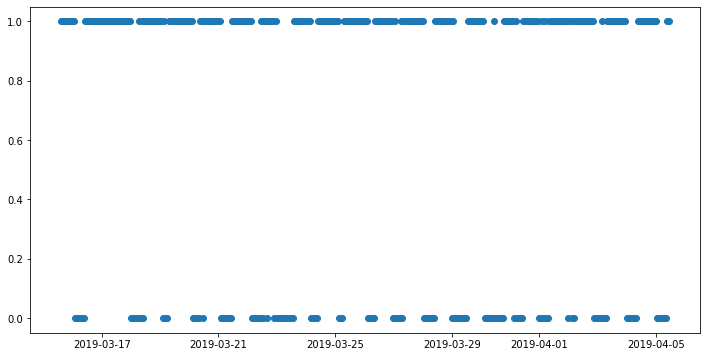

Percent Completion: 0.6772908366533864


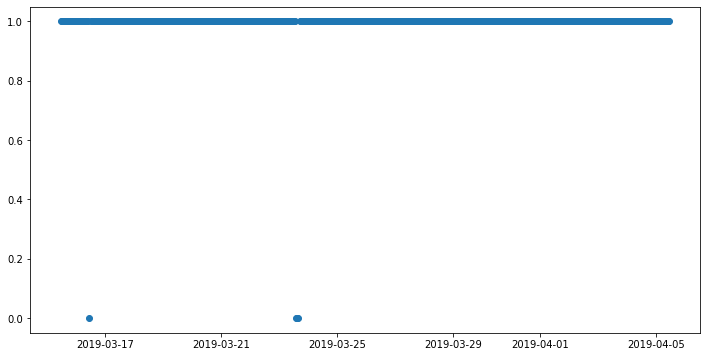

Percent Completion: 0.9920792079207921


In [110]:
for pid in df_to_save['Participant'].unique():
    fig, ax = plt.subplots(figsize=(12,6))
    df_by_id = df_to_save[df_to_save['Participant'] == pid]
    ax.scatter(df_by_id['Hour'],df_by_id['Has data?'])
    plt.show()
    plt.close()
    per = np.sum(df_by_id['Has data?'])/len(df_by_id)
    print(f'Percent Completion: {per}')

<div class="alert alert-block alert-warning">
<b>Example:</b> Use yellow boxes for examples that are not 
inside code cells, or use for mathematical formulas if needed.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>

<div class="alert alert-block alert-danger">
<b>Just don't:</b> In general, avoid the red boxes. These should only be
used for actions that might cause data loss or another major issue.
</div>